In [1]:
from ms_benchmark import predict_utils

from sklearn.metrics import roc_auc_score, auc, precision_recall_curve
import copy

from ms_benchmark import DATA_DIR
from model_wrapper import BNNMSModel, DynamicMSModel, StaticMSModel, RNNMSModel, AttentionMSModel

import matplotlib.pyplot as plt

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2 Physical GPUs, 1 Logical GPU


In [2]:
config = {
    #"Dynamic Baseline" : DynamicMSModel("s2rpzi9y"),
    #"Static Baseline" : StaticMSModel("fiv4p5xe"),
    "Bayesian NN": BNNMSModel(),
    #"RNN": RNNMSModel("gfbjt65v"),
    #"Attention": AttentionMSModel("a6o4f94s"),
}

In [3]:
results = {}
results_general = {}
for key, ms_model in config.items():
    metrics = {"ROC-AUC":[],"AUC-PR":[]}
    metrics_general = {"ROC-AUC":[]}
    center_dict = {}
    
    for fold in range(5):     
        ms_model.load_model_and_data(fold)
        df_test = ms_model.get_df()
        df_test["Center"] = df_test.PATIENT_ID.apply(lambda x : ("-").join(x.split("-")[:2]))

        y_true_test, y_pred_test = ms_model.predict_on_test()
        y_true_val, y_pred_val = ms_model.predict_on_val()
        
        metrics_general["ROC-AUC"].append(roc_auc_score(y_true_test,y_pred_test))
        
        for center in df_test.Center.unique():
            
            idx = df_test.loc[df_test["Center"]==center].index
            y_pred_ = y_pred_test[idx]
            y_true_ = y_true_test[idx]

            if y_true_.sum()==len(y_true_) or y_true_.sum()==0:
                #Only one class present - abort
                continue
            auc_roc = roc_auc_score(y_true_,y_pred_)
            precision, recall, thresholds = precision_recall_curve(y_true_, y_pred_)

            if center in center_dict:
                center_dict[center]["ROC-AUC"].append(auc_roc)
                center_dict[center]["AUC-PR"].append(auc(recall,precision))
            else:
                center_dict[center] = {"ROC-AUC":[auc_roc],"AUC-PR":[auc(recall,precision)]}
                
    results[key] = center_dict
    results_general[key] = metrics_general

In [4]:
import pandas as pd
import numpy as np

In [5]:
df = pd.DataFrame(columns = ["Model","Center","Fold","ROC-AUC"])
for model in results.keys():
    for center in results[model].keys():            
        for fold in range(len(results[model][center]["ROC-AUC"])):
            df = df.append({"Model":model,"Center":center,"Fold":fold,
                            "ROC-AUC":results[model][center]["ROC-AUC"][fold],
                            "AUC-PR":results[model][center]["AUC-PR"][fold]},ignore_index = True)

In [6]:
mu = df.groupby(["Model","Center"])[["ROC-AUC","AUC-PR"]].mean().reset_index().rename(columns={k: k+"_mean" for k in metrics.keys()})
std = df.groupby(["Model","Center"])[["ROC-AUC","AUC-PR"]].std().reset_index().rename(columns={k: k+"_std" for k in metrics.keys()})

In [7]:
res_df = mu.merge(std, on = ["Model","Center"])
res_df["Country"] = res_df["Center"].apply(lambda x : x.split("-")[0])

directory = DATA_DIR +"/MSBase2020/Cleaned/Static/"
df = pd.read_pickle(directory +"df.pkl")

num_pat_center_dict = dict(df.groupby("clinic")["PATIENT_ID"].nunique())

res_df["NumPats"] = res_df["Center"].map(num_pat_center_dict)

In [8]:
results_general

{'Bayesian NN': {'ROC-AUC': [0.7050066618582012,
   0.7320990549520554,
   0.7118538538085104,
   0.7109566662421065,
   0.7098049047149976]}}

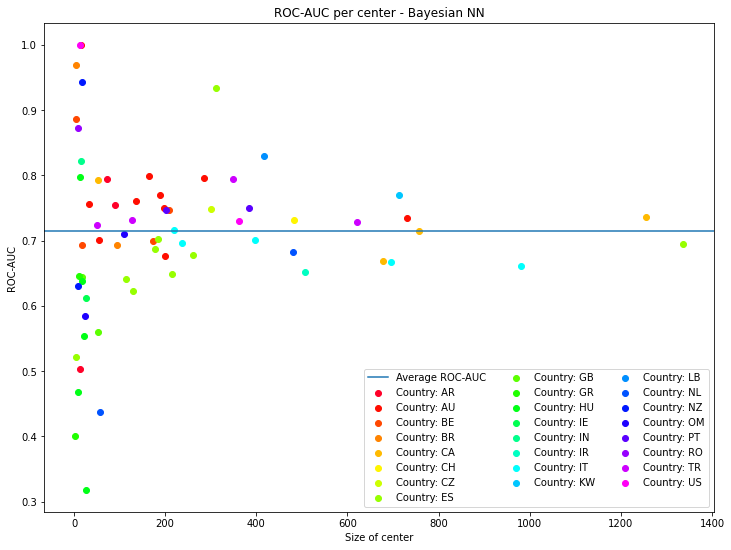

In [9]:
model_type = key
df_sub = res_df.loc[res_df.Model == model_type]

plt.figure(figsize=(12,9))

cm = plt.get_cmap('gist_rainbow')
country_d = {country:i for i,country in enumerate(df_sub["Country"].unique())}
for i,country in enumerate(df_sub["Country"].unique()):
    df_sub_ = df_sub.loc[df_sub.Country==country]
    plt.scatter(df_sub_["NumPats"].values,df_sub_["ROC-AUC_mean"].values,
                color = cm(country_d[country]/len(country_d)),
               label = "Country: "+country)
plt.axhline(np.array(results_general[model_type]["ROC-AUC"]).mean(),label = "Average ROC-AUC")
plt.xlabel("Size of center")
plt.ylabel("ROC-AUC")
plt.title(f"ROC-AUC per center - {model_type}")
plt.legend(ncol = 3,loc = "lower right")
plt.savefig(f"./plots/center_{model_type}.pdf")
plt.show()